<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocesado-de-los-datos:" data-toc-modified-id="Preprocesado-de-los-datos:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocesado de los datos:</a></span></li><li><span><a href="#Linear--vs-Trees-based-Models" data-toc-modified-id="Linear--vs-Trees-based-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear- vs Trees-based Models</a></span><ul class="toc-item"><li><span><a href="#Clasificación:" data-toc-modified-id="Clasificación:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clasificación:</a></span><ul class="toc-item"><li><span><a href="#Regresión-Logística:" data-toc-modified-id="Regresión-Logística:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Regresión Logística:</a></span></li><li><span><a href="#Árboles-de-Clasificación:" data-toc-modified-id="Árboles-de-Clasificación:-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Árboles de Clasificación:</a></span></li><li><span><a href="#Muestras-Desbalanceadas:" data-toc-modified-id="Muestras-Desbalanceadas:-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Muestras Desbalanceadas:</a></span></li></ul></li><li><span><a href="#Predicción:" data-toc-modified-id="Predicción:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Predicción:</a></span><ul class="toc-item"><li><span><a href="#Modelos-Lineales-Generalizados:" data-toc-modified-id="Modelos-Lineales-Generalizados:-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Modelos Lineales Generalizados:</a></span></li><li><span><a href="#Árboles-de-Regresión:" data-toc-modified-id="Árboles-de-Regresión:-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Árboles de Regresión:</a></span></li></ul></li></ul></li></ul></div>

# El Paquete CARET

**Objetivo:** En la presente práctica trataremos de profundizar en la utilización del paquete [CARET](https://topepo.github.io/caret/). Para ello, consideraremos las familias de métodos basados en modelos lineales y los basados en árboles, y el dataset `meteo.csv`, que podéis descargaros en el GitHub dedicado a este Máster ([meteo.csv](https://github.com/SantanderMetGroup/Master-Data-Science/blob/master/Data_mining/datasets/meteo.csv.)) y que hemos utilizado en sesiones anteriores. Dicho dataset contiene en la primera columna el valor de precipitación observado en Lisboa en el periodo 1979-2008 mientras que en las restantes contiene los valores observados de diferentes variables atmosféricas en 40 puntos que cubren aproximadamente la Península Ibérica. Dichas variables serán los `predictores` del modelo mientras que la precipitación será nuestra variable objetivo. En particular los predictores son:

* Altura geopotencial en 500 hPa (columnas 2:41),
* Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161), 
* Temperatura del aire en superficie (columnas 162:201),
* Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y 
* Presión al nivel del mar (columnas 282:321)


Finalmente, para evaluar los resultados obtenidos con nuestros modelos consideraremos la librería [hydroGOF](https://www.rdocumentation.org/packages/hydroGOF/versions/0.4-0). **Nota:** El uso de esta librería nos simplificará los cálculos si bien los estadísticos utilizados pueden implementarse de forma explícita o están disponibles en otras librerías.

A continuación cargamos (y/o instalamos) las librerías que utilizaremos a lo largo de la práctica:

In [99]:
library(caret) ## Training the model
library(fields) ## Plotting
library(hydroGOF) ## Evaluation
library(pROC) ## Classification Evaluation
library(rpart) ## Tree-based model

## Preprocesado de los datos:

Carguemos en primer lugar los datos meteorológicos. Notad que predictores y predictando se encuentran en el mismo fichero de modo que separemos ambos por comodidad:

In [100]:
# loading data
data <- read.csv("~/Dropbox/M1966_DataMining/datasets/meteo.csv")
df.meteo <- data[, -1]; rm(data)
y <- df.meteo[, 1]  ## Predictando
x <- df.meteo[, -1]  ## Predictores

Al tratarse de datos de variables meteorológicas sobre un dominio espacial se pueden dar auto-correlaciones significativas entre los predictores y rangos de valores muy dispares entre ellos. ¿Afecta alguna de estas dos características a los modelos basados en árboles? ¿Y a los modelos lineales?

Veamos primero la matriz de correlación cruzada entre los predictores:

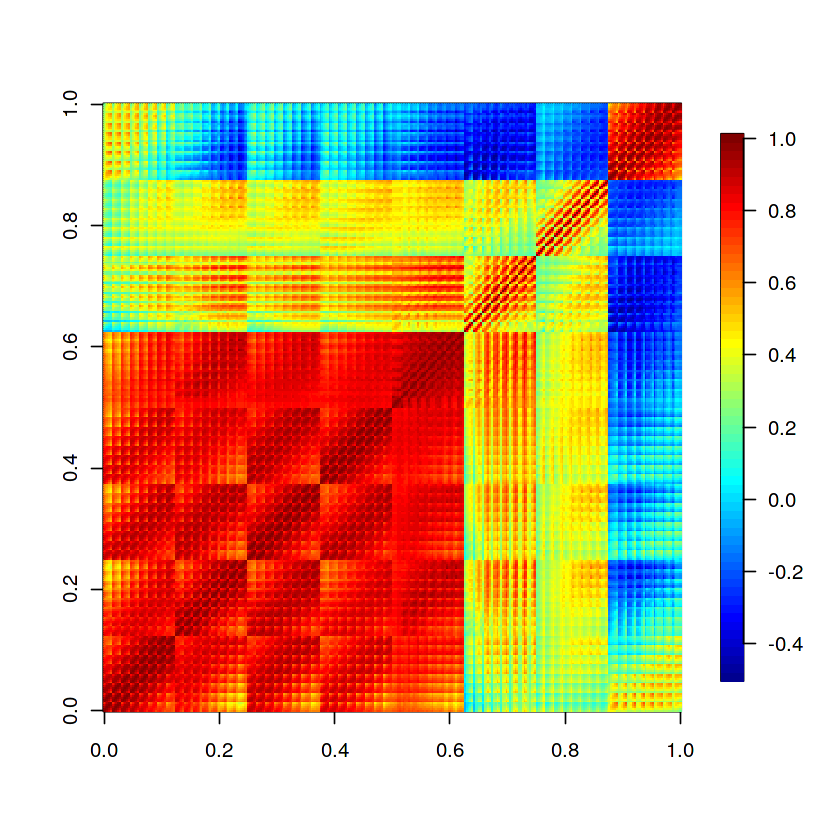

In [101]:
xCorr <- cor(x)
par(mfrow=c(1,1))
image.plot(xCorr)

Veamos ahora qué ocurre con los rangos de las variables consideradas:

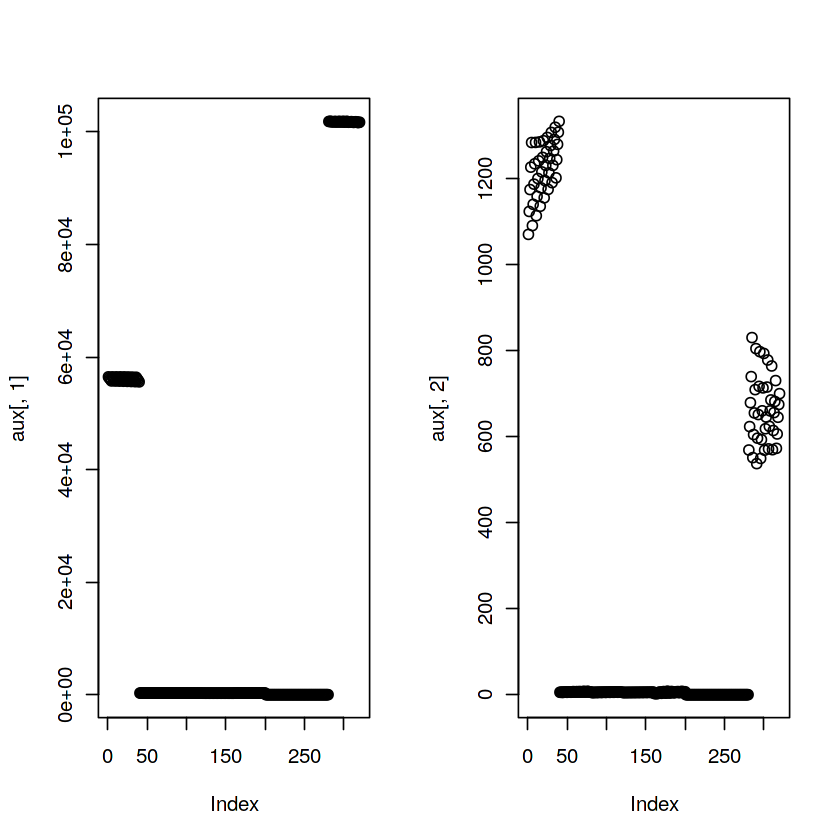

In [102]:
aux <- matrix(data = NA, nrow = ncol(x), 2)
aux[,1] <- apply(x, MARGIN = 2, FUN = mean, na.rm = TRUE)
aux[,2] <- apply(x, MARGIN = 2, FUN = sd, na.rm = TRUE)
par(mfrow=c(1,2))
plot(aux[,1])
plot(aux[,2])

Como vemos, existe una gran autocorrelación entre los diferentes predictores, los cuales además presentan tanto rangos como variabilidades que difieren hasta en 4 órdenes de magnitud. Para resolver ambos problemas, en caso de ser necesario para nuestros modelos, una técnica habitualmente aplicada es el Análisis de Componentes Principales sobre las variables normalizadas:

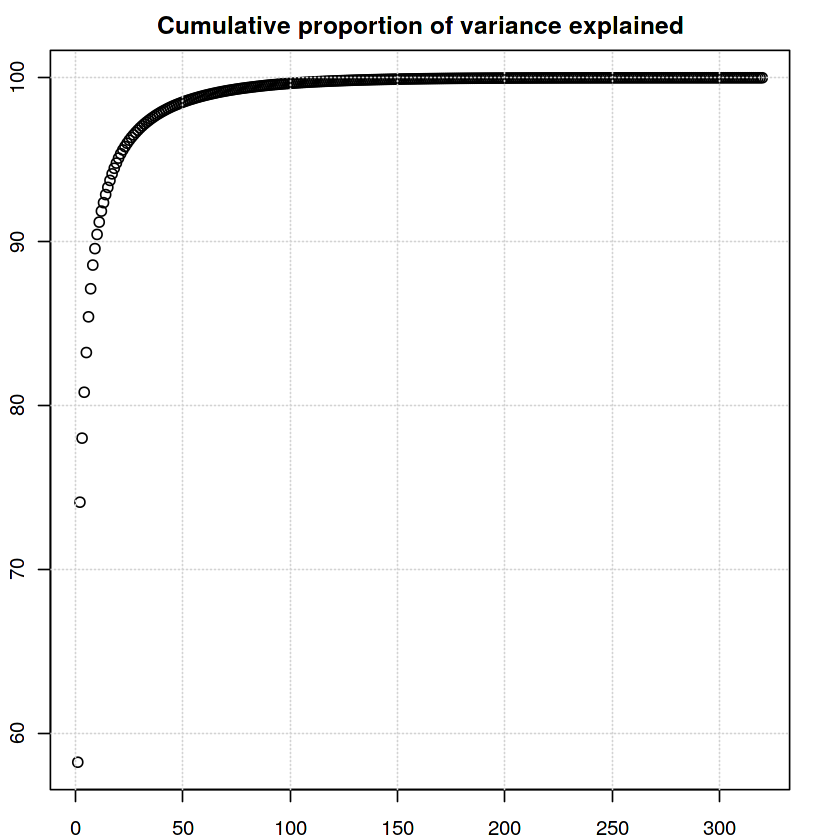

In [103]:
# PCA with R
PCA <- prcomp(x, center = TRUE, scale. = TRUE)
par(mfrow=c(1,1), mar=c(2.1,2.1,2.1,2.1))
plot(cumsum(PCA$sdev^2)/sum(PCA$sdev^2)*100,main="Cumulative proportion of variance explained")
grid()

Por un lado, la proporción de varianza explicada nos da un criterio para reducir la dimensión del problema, es decir reducir el número de predictores del modelo. Por otro lado, en el espacio de las PCAs las diferentes dimensiones son independientes:

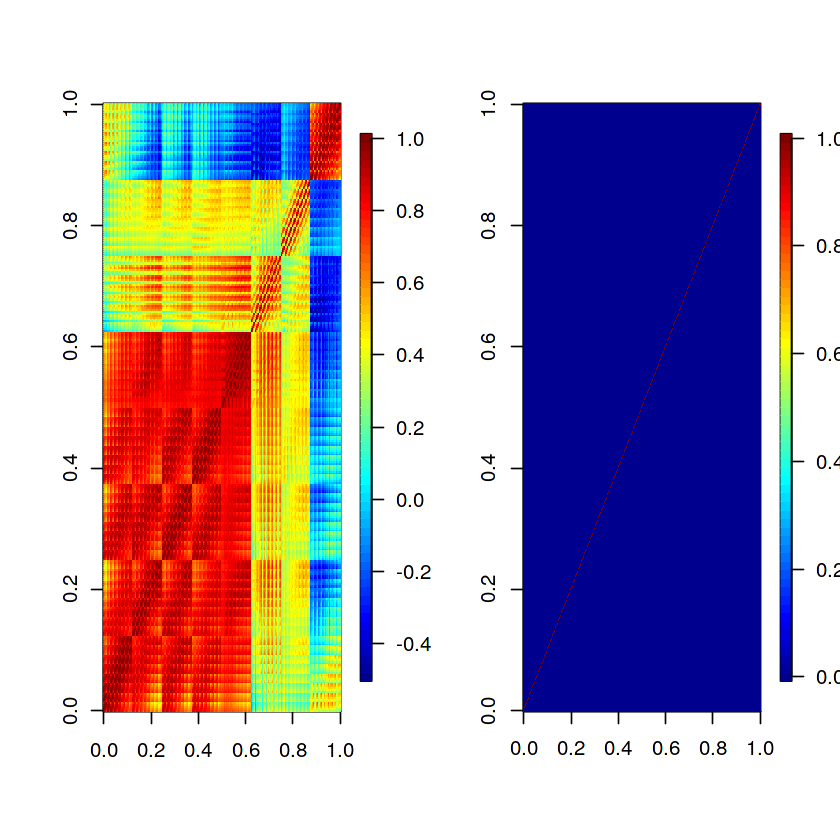

In [104]:
pcaCorr <- cor(PCA$x)
par(mfrow=c(1,2))
image.plot(xCorr)
image.plot(pcaCorr)

En adelante consideraremos las 50 primeras PCAs para el entrenamiento y aplicación de los modelos. ¿Con qué varianza explicada se corresponde?

In [105]:
print(cumsum(PCA$sdev[1:50]^2)/sum(PCA$sdev^2)*100)

 [1] 58.22748 74.09688 78.00651 80.80834 83.23083 85.41027 87.12340 88.56891
 [9] 89.57316 90.44000 91.19128 91.86198 92.37748 92.86927 93.31144 93.73552
[17] 94.13585 94.47848 94.79342 95.09655 95.36363 95.59608 95.80465 96.00553
[25] 96.19090 96.35968 96.51440 96.66293 96.80242 96.93679 97.06009 97.17861
[33] 97.28529 97.38907 97.48892 97.58256 97.67308 97.75856 97.83745 97.91617
[41] 97.98793 98.05823 98.12651 98.18961 98.25215 98.30878 98.36299 98.41548
[49] 98.46684 98.51634


En el caso de la variable objetivo debemos tener en cuenta el carácter dual de la precipitación. Por un lado, la ocurrencia de precipitación da lugar a un problema de clasificación mientras que, para los días de precipitación, la aproximación de la cantidad de precipitación da lugar a un problema de predicción. Consideraremos el umbral de discretización 1 mm que define la ocurrencia de precipitación (Wet days). Puedes consultar más detalles de la definición en la web de [ECA&D](https://www.ecad.eu//indicesextremes/indicesdictionary.php).

In [106]:
occu <- as.numeric(y > 1) ## Ocurrencia de precipitacion
occu[which(y <= 1)] <- 0
occu[which(y > 1)] <- 1
y[1:10]
occu[1:10]

[1] 10.9  0.6 13.0  0.0  0.0  1.2  1.1  0.0  0.0  0.7

[1] 1 0 1 0 0 1 1 0 0 0

## Linear- vs Trees-based Models

Una vez hemos definido las variables predictoras y objetivo, pasemos a identificar las familias de modelos a utilizar dentro del paquete CARET. ¿Contiene alguna implementación para los modelos lineales y basados en árboles? En caso afirmativo, ¿se consideran ambos casos: Clasificación y Predicción?

Definamos ahora el esquema de validación:

In [107]:
? trainControl

Entre las opciones vemos que podemos establecer:
 * Método de validación cruzada. ¿Qué método sería adecuado aplicar?
 * Preprocesado de los datos. ¿Es necesario algún preprocesado? (`? preProcess`)
 * Los parámetros de búsqueda del modelo óptimo, ¿qué parametros podemos ajustar?

En base a lo discutido anteriormente, definamos, por ejemplo, el siguiente flujo de entrenamiento:

In [108]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50))

Es decir, consideraremos un 10-fold sobre las 50 primeras PCAs. Veamos, a modo de ejemplo, como sería la aplicación sobre un fold:

In [109]:
indTrain <- createDataPartition(y,p=0.9,list=FALSE)
xTrain <- x[indTrain,]
yTrain <- y[indTrain]

xTest <- x[-indTrain,]
yTest <- y[-indTrain]
c(length(y),length(yTrain),length(yTest))

[1] 10958  9863  1095

Sobre el conjunto de `train` debemos obtener las 50 primeras PCAs: 

In [110]:
# PCA with R
PCA <- prcomp(xTrain, center = TRUE, scale. = TRUE)
pcaTrain <- PCA$x[,1:50]
dim(pcaTrain)

[1] 9863   50

Proyectar las coordenadas del conjunto de `test` en el espacio de las PCAs:

In [111]:
pcaTest <- predict(PCA, newdata = xTest)
dim(pcaTest)

[1] 1095  320

Y seleccionar de nuevo las 50 primeras coordenadas:

In [112]:
pcaTest <- pcaTest[,1:50]

Ahora aprendemos el modelo en el conjunto de `train` y lo usamos para predecir los valores en el conjunto de `test`:

In [113]:
## Regresion logistica
dfTrain <- data.frame(y = occu[indTrain], x=pcaTrain)
model <- glm(y~., data = dfTrain, family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
table(occu[indTrain], outbin)
100*sum(diag(table(occu[indTrain], outbin))) / length(outbin)

   outbin
       0    1
  0 7550  374
  1  694 1245

[1] 89.17165

In [114]:
dfTest <- data.frame(y = occu[-indTrain], x=pcaTest)
out1 <- predict(model, newdata = dfTest, type = "response")
outbin1 <- as.double(out1 > 0.5)
table(occu[-indTrain], outbin1)
100*sum(diag(table(occu[-indTrain], outbin1))) / length(outbin1)

   outbin1
      0   1
  0 813  61
  1  78 143

[1] 87.30594

### Clasificación:

Resolveremos en primer lugar el problema de clasificación asociado a la predicción de lluvia/no lluvia. Para ello consideraremos la regresión logística y los árboles de clasificación como representantes de ambas aproximaciones. 

Realizaremos toda la fase de entrenamiento usando CARET y partiendo del flujo definido anteriormente, con las modificaciones pertinentes asociadas a ambos métodos.

#### Regresión Logística:

En virtud de lo visto en el ejemplo anterior sobre la regresión logística, ¿hay algún parámetro que debamos incluir en el ajuste del modelo? En base a ello, definiremos el flujo de entrenamiento partiendo del ya definido:

In [115]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))

Definido el tipo de entrenamiento, ajustemos el modelo lineal:

In [116]:
dfTrain <- data.frame(y = as.factor(occu), x=x)
modelFit <- train(y ~ ., data=dfTrain, method="glm", trControl=trainParams, preProcess = "pca")
str(modelFit)

List of 23
 $ method      : chr "glm"
 $ modelInfo   :List of 15
  ..$ label     : chr "Generalized Linear Model"
  ..$ library   : NULL
  ..$ loop      : NULL
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: Factor w/ 1 level "parameter": 1
  .. ..$ class    : Factor w/ 1 level "character": 1
  .. ..$ label    : Factor w/ 1 level "parameter": 1
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 8 26 8 99 26 99 8 8
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x556603208bb0> 
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 9 25 30 19 25 19 9 30
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x556603208bb0> 
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  .. ..- attr(*, "srcref")= 'srcref' 

Evaluamos ahora el modelo respecto a toda la muestra:

In [117]:
yPred <- predict(modelFit,newdata = dfTrain)
confusionMatrix(as.factor(occu),yPred)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8377  421
         1  782 1378
                                         
               Accuracy : 0.8902         
                 95% CI : (0.8842, 0.896)
    No Information Rate : 0.8358         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6298         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9146         
            Specificity : 0.7660         
         Pos Pred Value : 0.9521         
         Neg Pred Value : 0.6380         
             Prevalence : 0.8358         
         Detection Rate : 0.7645         
   Detection Prevalence : 0.8029         
      Balanced Accuracy : 0.8403         
                                         
       'Positive' Class : 0              
                                         

Para algunos estadísticos de evaluación es necesario considerar las predicciones probabilísticas en lugar de las categóricas. Un ejemplo es la construcción de la curva ROC y la obtención a partir de ella del coeficiente AUC (Area Under the Curve):

In [118]:
yPred <- predict(modelFit,newdata = dfTrain, type="prob")
roc_obj <- roc(as.factor(occu), yPred[["1"]])
auc(roc_obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9325

#### Árboles de Clasificación:

Una vez resuelta la aproximación lineal, apliquemos un proceso similar para los árboles de clasificación. Notad que en esta ocasión el modelo en CARET viene definido por el método `rpart`. ¿En este caso debemos incluir la optimización de algún parámetro del árbol (`? rpart.control`)?

In [119]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))
dfTrain <- data.frame(y = as.factor(occu), x=x)
treeGrid <- expand.grid(cp = 10^c(-1:-5))
treeFit <- train(y ~ ., data=dfTrain, method="rpart", trControl=trainParams, tuneGrid = treeGrid, preProcess = "pca")
str(treeFit)

List of 23
 $ method      : chr "rpart"
 $ modelInfo   :List of 15
  ..$ label     : chr "CART"
  ..$ library   : chr "rpart"
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: Factor w/ 1 level "cp": 1
  .. ..$ class    : Factor w/ 1 level "numeric": 1
  .. ..$ label    : Factor w/ 1 level "Complexity Parameter": 1
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 7 26 26 19 26 19 7 26
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x55660bf78100> 
  ..$ loop      :function (grid)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 27 26 32 19 26 19 27 32
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x55660bf78100> 
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 33 25 57 19 25 19 33 57
  .. .. ..- attr(*, "srcf

Evaluamos ahora el modelo respecto a toda la muestra:

In [120]:
yTree <- predict(treeFit,newdata = dfTrain)
confusionMatrix(as.factor(occu),yTree)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8433  365
         1 1216  944
                                         
               Accuracy : 0.8557         
                 95% CI : (0.849, 0.8623)
    No Information Rate : 0.8805         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4646         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.8740         
            Specificity : 0.7212         
         Pos Pred Value : 0.9585         
         Neg Pred Value : 0.4370         
             Prevalence : 0.8805         
         Detection Rate : 0.7696         
   Detection Prevalence : 0.8029         
      Balanced Accuracy : 0.7976         
                                         
       'Positive' Class : 0              
                                         

Incluyendo el AUC para comparar adecuadamente ambos modelos:

In [121]:
yTree <- predict(treeFit,newdata = dfTrain, type="prob")
roc_obj <- roc(as.factor(occu), yTree[["1"]])
auc(roc_obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8009

#### Muestras Desbalanceadas:

A la vista de los resultados anteriores, ¿se observa algún problema asociado a la frecuencia de los casos positivos y negativos? Este problema se conoce como desbalanceo de la muestra y hay diferentes aproximaciones para resolverlo, algunas de las cuales están recogidas en CARET. Ver la [Sección 11](https://topepo.github.io/caret/subsampling-for-class-imbalances.html).

### Predicción:

Una vez resuelta la parte binaria de la precipitación, pasamos a predecir la cantidad para aquellos días en los cuales se haya dado precipitación. En el caso de los modelos lineales esta división es necesaria por las hipótesis impuestas sobre las funciones de enlace, el comportamiento de los residuos, etc... ¿Ocurre lo mismo para los modelos basados en árboles?

Consideremos la muestra asociada a los días de precipitación:

In [122]:
indRain <- which(y > 1)
dfTrain <- data.frame(y = y[indRain], x=x[indRain,])

Notar que la variable `indRain` contiene las posiciones de los días con precipitación y nos permitirá asignar los valores predichos a las posiciones correspondientes del vector de predicciones sobre todo el periodo.

#### Modelos Lineales Generalizados:

Como vimos en el problema de clasificación, realmente no tenemos ningún parámetro extra que ajustar en el GLM, de modo que podemos replicar el ajuste, esta vez considerando únicamente los datos de precipitación:

In [123]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))
modelFit <- train(y ~ ., data=dfTrain, method="glm", trControl=trainParams, preProcess = "pca")
str(modelFit)

List of 23
 $ method      : chr "glm"
 $ modelInfo   :List of 15
  ..$ label     : chr "Generalized Linear Model"
  ..$ library   : NULL
  ..$ loop      : NULL
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: Factor w/ 1 level "parameter": 1
  .. ..$ class    : Factor w/ 1 level "character": 1
  .. ..$ label    : Factor w/ 1 level "parameter": 1
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 8 26 8 99 26 99 8 8
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x556603275220> 
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 9 25 30 19 25 19 9 30
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x556603275220> 
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  .. ..- attr(*, "srcref")= 'srcref' 

Obtenemos ahora las predicciones sobre los días de precipitación:

In [124]:
yPred <- predict(modelFit,newdata = dfTrain)

Validemos ahora la predicción obtenida con diferentes parámetros:

 * Day-to-day correspondence: ¿qué medidas conoces que evalúen la correspondencia entre ambas series?
 * Accuracy: ¿qué medidas de precisión conoces?
 * Distributional similarity: ¿qué medidas de comparación de la distribución estadística conoces?

Revisar los parámetros de validación incluidos en el paquete `hydroGOF` y ver si alguno se corresponde con las características antes expuestas.

In [125]:
## Por ejemplo, RMSE:
RMSEglm=rmse(yPred,dfTrain$y)
print(RMSEglm)

[1] 9.815054


El Kolmogorov-Smirnov Test (? ks.test) ¿con qué característica de las anteriores se corresponde?

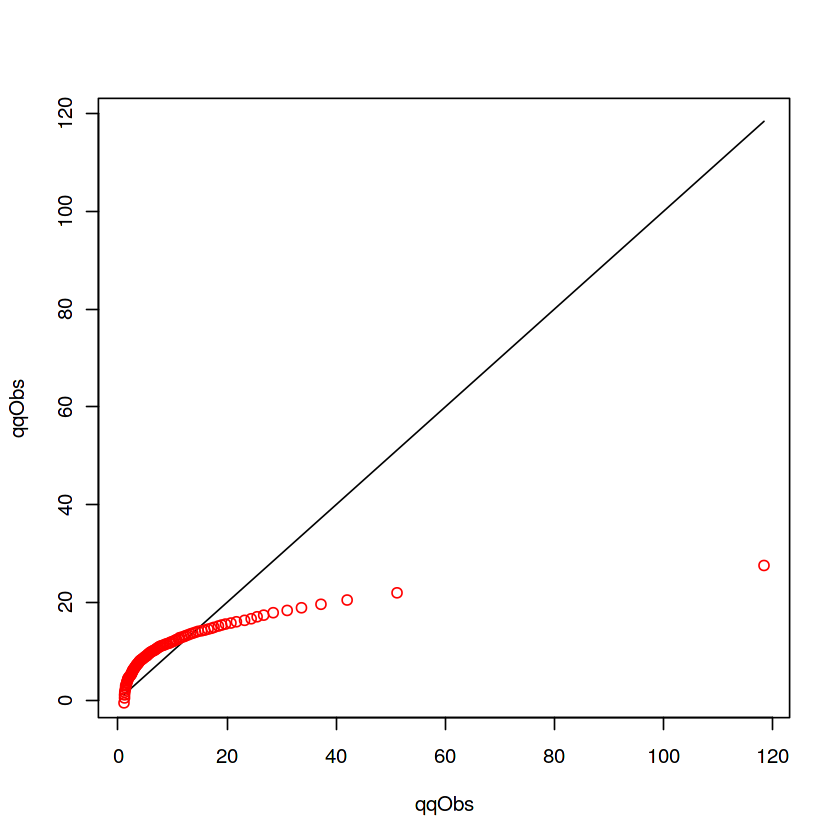

In [126]:
qqObs <- quantile(dfTrain$y, probs = seq(0, 1, 0.01), na.rm = TRUE)
qqPrd <- quantile(yPred, probs = seq(0, 1, 0.01), na.rm = TRUE)
par(mfrow=c(1,1))
plot(qqObs,qqObs, type = "l")
points(qqObs,qqPrd, col = "red")

A la vista del gráfico anterior, ¿cómo se está comportando nuestro modelo?

#### Árboles de Regresión:

En base a lo visto en los puntos anterior, extiende el análisis a los métodos basados en árboles y comparar con los resultados obtenidos para el modelo lineal.